In [8]:
!pip install pymysql sqlalchemy pandas gspread oauth2client


In [10]:
json_keyfile_path = 'database-460309-5ced614aef8f.json'


In [11]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

# Define the scope
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]

# Authenticate
credentials = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(credentials)

# Open your Google Sheet by name or URL
sheet = client.open("Fertilizer_DB")  # Use your sheet name or URL

# Use expected_headers parameter to handle duplicate or empty headers
worksheet1 = sheet.worksheet("seeds")
# Get all values including headers
all_values1 = worksheet1.get_all_values()
headers1 = all_values1[0]  # First row contains headers
data1 = all_values1[1:]    # Rest of the rows contain data
ds = pd.DataFrame(data1, columns=headers1)

worksheet2 = sheet.worksheet("pesticides")
all_values2 = worksheet2.get_all_values()
headers2 = all_values2[0]
data2 = all_values2[1:]
dp = pd.DataFrame(data2, columns=headers2)

worksheet3 = sheet.worksheet("pesticides_purchase")
all_values3 = worksheet3.get_all_values()
headers3 = all_values3[0]
data3 = all_values3[1:]
dpp = pd.DataFrame(data3, columns=headers3)

worksheet4 = sheet.worksheet("pesticides_sales")
all_values4 = worksheet4.get_all_values()
headers4 = all_values4[0]
data4 = all_values4[1:]
dps = pd.DataFrame(data4, columns=headers4)

print(dps.head())  # Preview
print(dpp.head())

         Date product_id Quantity
0  12/06/2024          7        3
1  16/06/2024          7        4
2  17/06/2024          7        3
3  22/06/2024          7        3
4  23/06/2024          7        4
         Date product_id Quantity
0  15/05/2024          7       80
1  20/05/2024         10       60
2  20/05/2024         11       55
3  25/05/2024          1       50
4  25/05/2024          2       50


In [12]:
from sqlalchemy import create_engine
import urllib.parse

user = "root"
password = "Tejaswi@1"
host = "localhost"
port = "3306"
database = "fertilizer_shop"

encoded_password = urllib.parse.quote_plus(password)

engine = create_engine(f"mysql+pymysql://{user}:{encoded_password}@{host}:{port}/{database}")

# Write to table
dpp.to_sql('pesticides_purchase', con=engine, if_exists='replace', index=False)
dp.to_sql('pesticides', con=engine, if_exists='replace', index=False)# use 'append' to keep existing data
dps.to_sql('pesticides_sales', con=engine, if_exists='replace', index=False)

104

In [1]:
pip install prophet mysql-connector-python pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import mysql.connector

# MySQL connection
conn = mysql.connector.connect(
    host='localhost',    # or your MySQL host
    user='root',
    password='Tejaswi@1',
    database='fertilizer_shop'
)

# Query sales data
query = """
SELECT Date, Quantity
FROM pesticides_sales
ORDER BY Date
"""

df = pd.read_sql(query, conn)

# Aggregate sales per day
df = df.groupby('Date').sum().reset_index()
df.columns = ['ds', 'y']  # Prophet needs these column names

conn.close()

df.head()


C:\Users\devar\AppData\Local\Temp\ipykernel_26632\3774969803.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,ds,y
0,01/08/2024,434
1,01/09/2024,4
2,01/10/2024,3
3,02/09/2024,5
4,03/07/2024,53


21:12:54 - cmdstanpy - INFO - Chain [1] start processing
21:12:55 - cmdstanpy - INFO - Chain [1] done processing


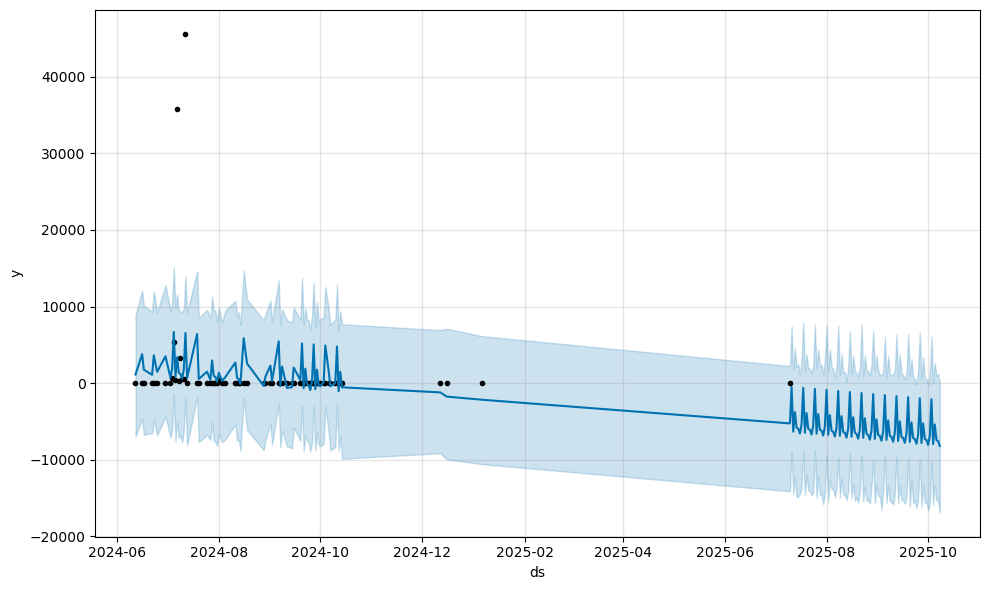

In [6]:
# Assistant
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your dataframe with date column
# First, ensure your date column is properly formatted
# If your date column is named 'ds' and has format day/month/year:
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')  # Specify the correct format

# Build model
model = Prophet()
model.fit(df)

# Create future dataframe
future = model.make_future_dataframe(periods=90)  # forecast 90 days

# Forecast
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.show()